**Import Libraries**

In [38]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import timm

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from lightly.loss import NTXentLoss
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres fine tuning
LEARNING_RATE = 1e-2
TEST_SIZE = 0.8
EPOCHS = 6
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data (Stage 1)**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing (Stage 1)**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Remove all No finding labels for stage 1 training
labels_df_stage_2 = labels_df
labels_df = labels_df[labels_df['No_Finding'] != 1]

# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 41466
Test size: 10293


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),
    
    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [10]:
train_size = int(TEST_SIZE * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# **Step 3: Build the Model (Stage 1)**

**Initialize the Multi-Label Classifier Model**

In [12]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier[2] = nn.Linear(in_features=768, out_features=num_classes, bias=True)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

MultiLabelClassifier(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): Lay

**Define Loss Function and Optimizer**

# **Step 4: Train the Model (Stage 1)**

**Step 1: Train Classification Head Only**

In [13]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [14]:
# Only the classifier parameters will be updated
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer_head, step_size=2, gamma=0.1)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler once per epoch.
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_head, epochs=EPOCHS)

Epoch 1/6:   0%|          | 0/1037 [00:00<?, ?it/s]

Epoch 1/6: 100%|██████████| 260/260 [00:21<00:00, 12.13it/s, Loss=0.318]


Epoch 1/6 | Training Loss: 0.2929 | Validation Loss: 0.2830 | Mean Validation AUC: 0.7138


Epoch 2/6: 100%|██████████| 260/260 [00:20<00:00, 12.70it/s, Loss=0.298]


Epoch 2/6 | Training Loss: 0.2855 | Validation Loss: 0.2816 | Mean Validation AUC: 0.7210


Epoch 3/6: 100%|██████████| 260/260 [00:21<00:00, 12.26it/s, Loss=0.329]


Epoch 3/6 | Training Loss: 0.2763 | Validation Loss: 0.2761 | Mean Validation AUC: 0.7330


Epoch 4/6: 100%|██████████| 260/260 [00:20<00:00, 12.97it/s, Loss=0.294]


Epoch 4/6 | Training Loss: 0.2748 | Validation Loss: 0.2760 | Mean Validation AUC: 0.7361


Epoch 5/6: 100%|██████████| 260/260 [00:19<00:00, 13.21it/s, Loss=0.295]


Epoch 5/6 | Training Loss: 0.2731 | Validation Loss: 0.2750 | Mean Validation AUC: 0.7343


Epoch 6/6: 100%|██████████| 260/260 [00:19<00:00, 13.20it/s, Loss=0.316]


Epoch 6/6 | Training Loss: 0.2731 | Validation Loss: 0.2748 | Mean Validation AUC: 0.7345


**Step 2: Fine Tune Entire Network**

In [16]:
# Unfreeze all layers for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [17]:
# Use a lower learning rate for the whole network
optimizer_full = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer_full, step_size=2, gamma=0.1)

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Update the scheduler once per epoch.
        scheduler.step()

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_full, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 260/260 [00:20<00:00, 12.88it/s, Loss=0.261]


Epoch 1/6 | Training Loss: 0.2648 | Validation Loss: 0.2540 | Mean Validation AUC: 0.7889


Epoch 2/6: 100%|██████████| 260/260 [00:19<00:00, 13.65it/s, Loss=0.271]


Epoch 2/6 | Training Loss: 0.2480 | Validation Loss: 0.2476 | Mean Validation AUC: 0.8050


Epoch 3/6: 100%|██████████| 260/260 [00:19<00:00, 13.29it/s, Loss=0.276]


Epoch 3/6 | Training Loss: 0.2287 | Validation Loss: 0.2436 | Mean Validation AUC: 0.8146


Epoch 4/6: 100%|██████████| 260/260 [00:19<00:00, 13.32it/s, Loss=0.291]


Epoch 4/6 | Training Loss: 0.2236 | Validation Loss: 0.2439 | Mean Validation AUC: 0.8162


Epoch 5/6: 100%|██████████| 260/260 [00:19<00:00, 13.67it/s, Loss=0.29] 


Epoch 5/6 | Training Loss: 0.2191 | Validation Loss: 0.2433 | Mean Validation AUC: 0.8161


Epoch 6/6: 100%|██████████| 260/260 [00:18<00:00, 13.91it/s, Loss=0.298]

Epoch 6/6 | Training Loss: 0.2179 | Validation Loss: 0.2434 | Mean Validation AUC: 0.8164


# **Step 4: Data Processing (Stage 2)**

**Split Dataset**

In [19]:
# Include all labels including No finding i stage 2
labels_df = labels_df_stage_2

# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


**Create Datasets**

In [20]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [21]:
train_size = int(TEST_SIZE * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [31]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

# **Step 5: Build the Model (Stage 2)**

**Initialize the Multi-Label Classifier Model**

In [32]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, model, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = model.base_model

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier[2] = nn.Linear(self.base_model.classifier[2].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier(model)
model.to(device)

MultiLabelClassifier(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): Lay

**Define Loss Function, Optimizer and Scheduler**

In [33]:
criterion = nn.BCEWithLogitsLoss()

# Separate parameters: exclude head parameters from the base group
base_params = [p for n, p in model.base_model.named_parameters() if not n.startswith("classifier.2")]
head_params = list(model.base_model.classifier[2].parameters())


optimizer = optim.Adam([
    {'params': base_params, 'lr': 2e-5},  # lower learning rate for base layers
    {'params': head_params, 'lr': 8e-5}   # higher learning rate for head layers
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[2e-5, 8e-5],
    total_steps=EPOCHS * len(train_loader),
    anneal_strategy='linear'
)

# **Step 6: Train the Model (Stage 2)**

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Update learning rates per batch
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())

            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 562/562 [00:21<00:00, 26.14it/s, Loss=0.113] 


Epoch 1/6 | Training Loss: 0.2608 | Validation Loss: 0.1583 | Mean Validation AUC: 0.7406


Epoch 2/6: 100%|██████████| 562/562 [00:23<00:00, 24.37it/s, Loss=0.122] 


Epoch 2/6 | Training Loss: 0.1521 | Validation Loss: 0.1429 | Mean Validation AUC: 0.8224


Epoch 3/6: 100%|██████████| 562/562 [00:22<00:00, 24.84it/s, Loss=0.122] 


Epoch 3/6 | Training Loss: 0.1437 | Validation Loss: 0.1400 | Mean Validation AUC: 0.8419


Epoch 4/6: 100%|██████████| 562/562 [00:22<00:00, 25.30it/s, Loss=0.128] 


Epoch 4/6 | Training Loss: 0.1398 | Validation Loss: 0.1389 | Mean Validation AUC: 0.8473


Epoch 5/6: 100%|██████████| 562/562 [00:22<00:00, 24.75it/s, Loss=0.121] 


Epoch 5/6 | Training Loss: 0.1369 | Validation Loss: 0.1379 | Mean Validation AUC: 0.8539


Epoch 6/6: 100%|██████████| 562/562 [00:23<00:00, 24.31it/s, Loss=0.123] 


Epoch 6/6 | Training Loss: 0.1351 | Validation Loss: 0.1378 | Mean Validation AUC: 0.8548


# **Step 9: Evaluate the Model**

In [42]:
# TTA transforms using the new methods
tta_transforms = [
    lambda img: img,  # Original image
    lambda img: transforms.RandomHorizontalFlip(p=0.5)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [43]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [01:04<00:00, 10.88it/s]


**Compute Metrics for Each Label**

In [44]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.904145,0.286001,0.836407
Consolidation,0.957343,0.000000,0.830668
Infiltration,0.814345,0.213267,0.720531
Pneumothorax,0.957163,0.384268,0.903326
Edema,0.979412,0.037736,0.903351
Emphysema,0.977079,0.395266,0.939543
Fibrosis,0.983673,0.000000,0.822873
Effusion,0.901588,0.505633,0.893250
Pneumonia,0.986813,0.000000,0.756842
Pleural_Thickening,0.970306,0.017804,0.821327


**Plot ROC curves for each label**

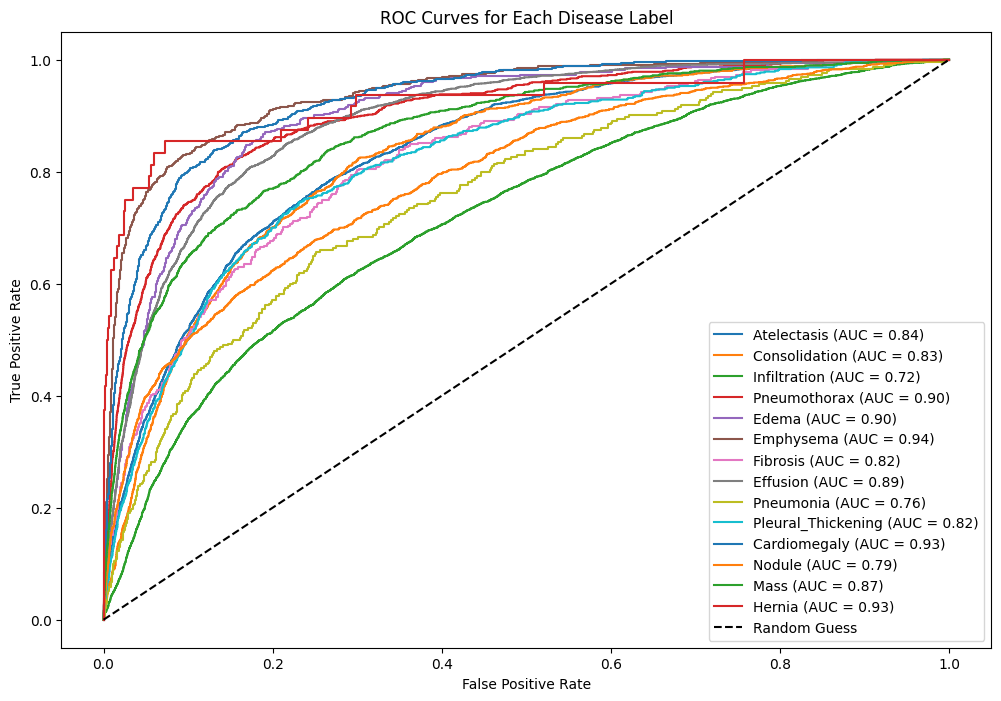

In [45]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

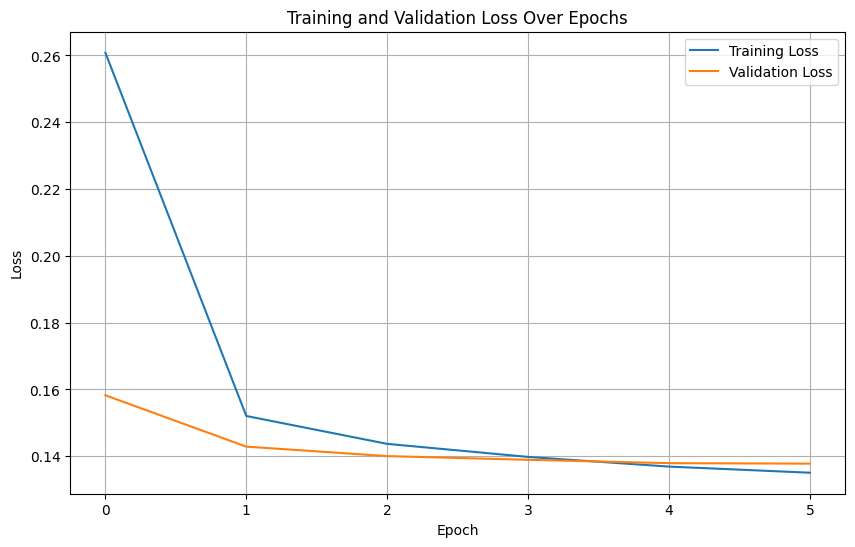

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

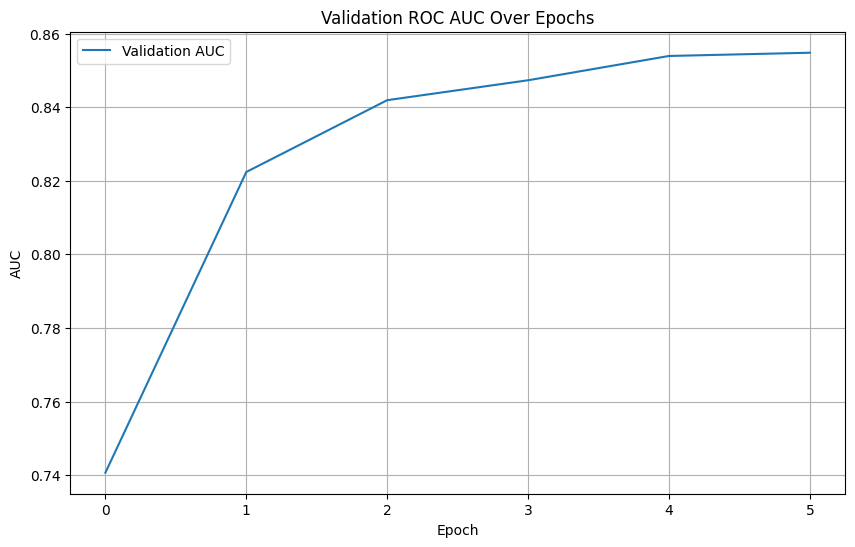

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()